In [1]:
import sys
import itertools
import warnings
sys.path.append('../uniswap_v3_strategy/')
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from loader import get_gas_price_per_block, get_swap_data_per_block
from strategy import run_put_strategy_multi
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
swap_path = '../data/eth_price.csv'
gas_price = get_gas_price_per_block(eth_path=swap_path, gas_path='../data/gas_price.csv')
swap_data = get_swap_data_per_block(swap_path)
range_percentages = [10*i for i in range(1,4)]
durations = [f'{i} day' for i in [3,7,14]]

In [3]:
def multi_range(price_df, params):
    ub = (price_df.price*(1 + params['range_percent']/100)).dropna()
    lb = price_df.price*(1.0001)
    lb1 = price_df.price*(1.0001)
    ub1 = (price_df.price*(1 + params['range_percent2']/100)).dropna()
    return lb, ub, lb1, ub1 

In [4]:
out = Parallel(n_jobs=18, verbose=True)(delayed(run_put_strategy_multi)
                (amount_invested = 1e6,swap_path=swap_path, gas_price=gas_price,disable_costs=False,
                decimal_diff=12, swap_cost=13e-3, duration=duration,  get_range=multi_range, params={'range_percent':range_percentage, 'range_percent2':range_percentage})
                for range_percentage, duration in itertools.product(range_percentages, durations))

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   4 out of   9 | elapsed:  1.7min remaining:  2.1min
[Parallel(n_jobs=18)]: Done   9 out of   9 | elapsed:  1.7min finished


In [5]:
def rets(out):
    returns  = 100*(out.iloc[-1]-out.iloc[0])/out.iloc[0]
    return round(returns,2)

def max_drawdown(out):
    rets = out.pct_change().dropna()
    cum_rets = (1+rets).cumprod()
    max_rets = (1+rets).cumprod().cummax()
    draw_downs = 100*(max_rets-cum_rets)/max_rets
    return round(max(draw_downs), 2)

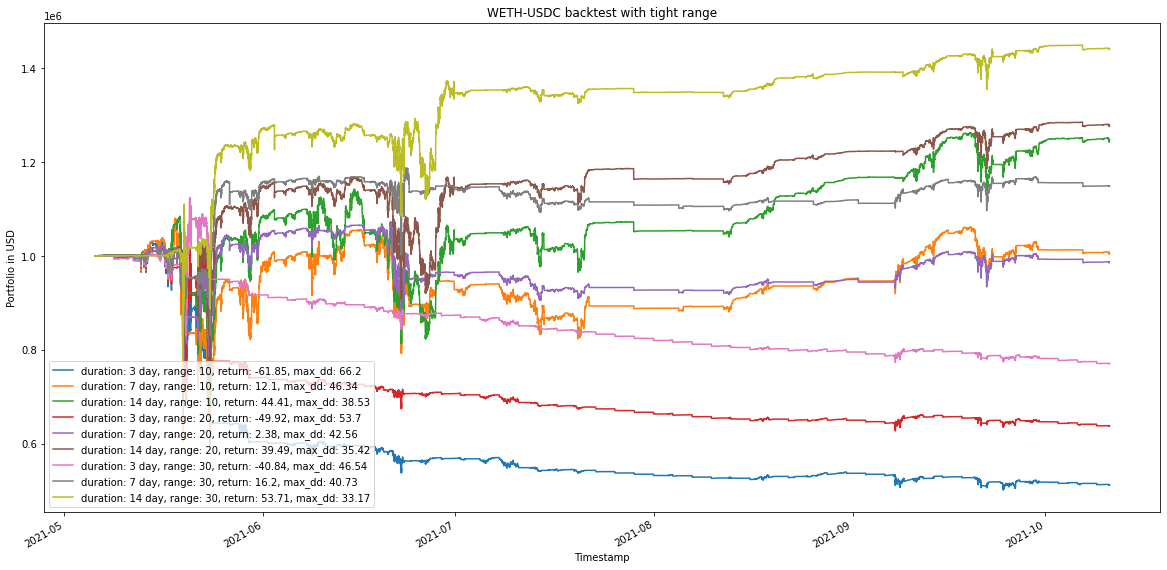

In [6]:
pool_name = 'WETH-USDC'
for i in range(len(out)):
    output =  out[i]['holdings']['usd_with_fees'] + out[i]['holdings_2']['idle_usd']+out[i]['holdings_2']['usd_with_fees']
    output.plot(figsize=(20, 10))
L = plt.legend(loc='lower left')
count = 0
for i in range(len(out)):
    L.get_texts()[count].set_text(f'duration: {out[i]["duration"]}, range: {out[i]["range_percent"]}, return: {rets(out[i]["holdings"]["usd_with_fees"])}, max_dd: {max_drawdown(out[i]["holdings"]["usd_with_fees"])}')
    count+=1
plt.title(f'{pool_name} backtest with tight range')
plt.xlabel('Timestamp')
plt.ylabel('Portfolio in USD')
# plt.savefig(f'./results/With_Fees/{POOL_NAME}/{POOL_NAME}_backtest_with_all.png')
plt.show()